Monte carlo simulation based on the Eq 4 of the Paper

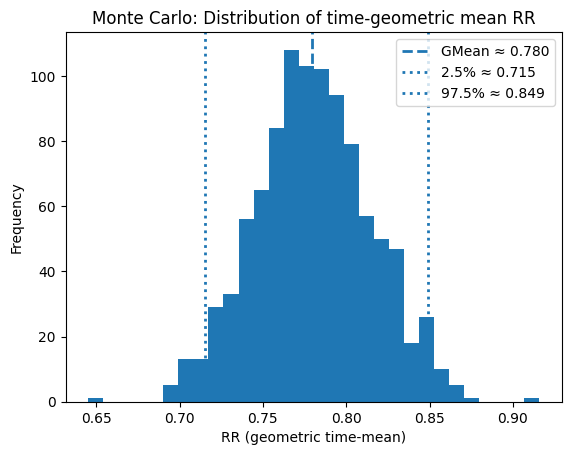

Pooled (over time) RR — Geometric Monte Carlo summary (n_iters=1000):
  Geometric Mean : 0.780
  Std dev        : 0.035
  95% CI         : [0.715, 0.849]
  MCSE (mean)    : 0.001
  CSV : /hkfs/home/haicore/hgf_dlr/hgf_uyx7543/rr_geometric_summary.csv
  PNG : /hkfs/home/haicore/hgf_dlr/hgf_uyx7543/rr_geometric_histogram.png


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# 1) INPUTS (replace these)
# -----------------------------
Pf_fe = np.array([
    1419.26661183071,
    2105.79266233086,
    549.513954174742,
    284.547904019079,
    142.202501627159,
    0.466854304198928,
    442.192947462177,
    474.174727803004,
    365.68147040514,
    2016.28555853965,
    188.602641488766,
    1844.66513597327,
    0.015167110493628,
    0.015167110493628,
    1050.07192554818,
    14.9964014559792,
    62.7507015667559,
    2316.77107128403,
    981.034935532332,
    248.560064512672
]

, dtype=float)

Ex_Fx = np.array([
    9322.83985200049,
    10347.6994003696,
    4539.04123726422,
    1935.17162673019,
    1175.75463362772,
    4.23782699250978,
    3896.68962949671,
    4126.37233024126,
    2431.52571636402,
    6240.54377905111,
    1052.27779134385,
    4932.71001272151,
    3647.6139981373,
    0.0729841339338706,
    17221.8338522091,
    133.758213041303,
    568.45599958065,
    3661.04414511273,
    7212.04657409339,
    1547.49903605245
]
)

Pf_c  = np.array([
    1416213.32327359,
    1416213.32327359,
    1416213.32327359,
    1416213.32327359,
    1416213.32327359,
    1229278.82634885,
    1229279.82634885,
    1122255.77039764,
    2561471.07719376,
    1611136.04374707,
    1611137.04374707,
    2010236.29273693,
    2109380.5083538,
    2109381.5083538,
    1172847.9065786,
    1818322.59524775,
    1818323.59524775,
    1818324.59524775,
    2095606.77647071,
    2305259.91124144
]


                   
, dtype=float)

P_tot = np.array([ 13603850.531494774] * 20, dtype=float)

n_iters   = 1000
rel_sigma = 0.10  # 10% relative uncertainty

# -----------------------------
# 2) Helpers
# -----------------------------
def draw_lognormal_samples(mu_array, rel_sigma, n):
    mu_array = np.asarray(mu_array, dtype=float)
    if np.any(mu_array <= 0):
        raise ValueError("All input values must be > 0 for lognormal sampling.")
    s = float(rel_sigma)
    m = np.log(mu_array) - 0.5 * (s**2)
    eps = np.random.normal(loc=0.0, scale=s, size=(n, mu_array.size))
    return np.exp(m + eps)

def geometric_mean(arr, axis=None):
    """Compute geometric mean safely (avoiding underflow)."""
    arr = np.asarray(arr)
    return np.exp(np.mean(np.log(arr), axis=axis))

# -----------------------------
# 3) Monte Carlo
# -----------------------------
T = Pf_fe.size
if not (Ex_Fx.size == Pf_c.size == P_tot.size == T):
    raise ValueError("All input arrays must have the same length.")

Pf_fe_s = draw_lognormal_samples(Pf_fe, rel_sigma, n_iters)
Ex_Fx_s = draw_lognormal_samples(Ex_Fx, rel_sigma, n_iters)
Pf_c_s  = draw_lognormal_samples(Pf_c,  rel_sigma, n_iters)
P_tot_s = draw_lognormal_samples(P_tot, rel_sigma, n_iters)

RR_s = (Pf_fe_s / Ex_Fx_s) / (Pf_c_s / P_tot_s)  # shape (n, T)

# -----------------------------
# 4) Summaries (geometric)
# -----------------------------
# Per-time summaries
rr_gmean_t = geometric_mean(RR_s, axis=0)
rr_std_t   = RR_s.std(axis=0, ddof=1)
rr_p025_t  = np.quantile(RR_s, 0.025, axis=0)
rr_p975_t  = np.quantile(RR_s, 0.975, axis=0)

# Distribution of geometric time-mean RR per iteration
RR_time_gmean = geometric_mean(RR_s, axis=1)
pooled_gmean  = geometric_mean(RR_time_gmean)
pooled_std    = float(RR_time_gmean.std(ddof=1))
pooled_p025   = float(np.quantile(RR_time_gmean, 0.025))
pooled_p975   = float(np.quantile(RR_time_gmean, 0.975))
mcse          = pooled_std / np.sqrt(n_iters)

# Per-time summary table
df_summary = pd.DataFrame({
    "t": np.arange(1, T+1),
    "RR_gmean": rr_gmean_t,
    "RR_std": rr_std_t,
    "RR_p2.5": rr_p025_t,
    "RR_p97.5": rr_p975_t,
})

# Save CSV
out_csv = Path("rr_geometric_summary.csv")
df_summary.to_csv(out_csv, index=False)

# -----------------------------
# 5) Plot histogram (geometric mean)
# -----------------------------
plt.figure()
plt.hist(RR_time_gmean, bins=30)
plt.axvline(pooled_gmean, linestyle="--", linewidth=2, label=f"GMean ≈ {pooled_gmean:.3f}")
plt.axvline(pooled_p025, linestyle=":", linewidth=2, label=f"2.5% ≈ {pooled_p025:.3f}")
plt.axvline(pooled_p975, linestyle=":", linewidth=2, label=f"97.5% ≈ {pooled_p975:.3f}")
plt.title("Monte Carlo: Distribution of time-geometric mean RR")
plt.xlabel("RR (geometric time-mean)")
plt.ylabel("Frequency")
plt.legend()
out_png = Path("rr_geometric_histogram.png")
plt.savefig(out_png, bbox_inches="tight", dpi=150)
plt.show()

# -----------------------------
# 6) Print key results
# -----------------------------
print(f"Pooled (over time) RR — Geometric Monte Carlo summary (n_iters={n_iters}):")
print(f"  Geometric Mean : {pooled_gmean:.3f}")
print(f"  Std dev        : {pooled_std:.3f}")
print(f"  95% CI         : [{pooled_p025:.3f}, {pooled_p975:.3f}]")
print(f"  MCSE (mean)    : {mcse:.3f}")
print("  CSV :", out_csv.resolve())
print("  PNG :", out_png.resolve())